In [138]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
from sklearn.preprocessing import LabelEncoder

# utils
import time
from tqdm import tqdm, tqdm_notebook
import datetime
import random,math
import warnings
warnings.filterwarnings(action='ignore')
#pd.options.plotting.backend = "plotly" # https://plotly.com/python/pandas-backend/

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import Normalizer # https://heeya-stupidbutstudying.tistory.com/34
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestCentroid
from scipy import stats
from sklearn.manifold import TSNE

### Network structure features

* degree centrality 의 평균 및 분산
* betweenness centrality 의 평균 및 분산
* degree assortativity
* clustering coefficient
* radius
* community size

### 커뮤니티 분류 전 전체 네트워크 피쳐

In [94]:
dt.head()

,Id,Label,timeset,indegree,outdegree,Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering
0,31156,31156,NaN,3,3,6,6,0.306452,0.413158,6.225601e+01,0.0
1,42315,42315,NaN,239,1,240,9,0.229508,0.321117,1.349609e+04,0.0
2,35392,35392,NaN,255,1,256,5,0.333333,0.456667,5.523348e+03,0.0
3,54071,54071,NaN,7,1,8,20,0.086965,0.090116,4.359875e+02,0.0
4,53441,53441,NaN,341,1,342,19,0.095245,0.099498,2.904267e+07,0.0


In [98]:
dt = pd.read_csv('./net_before.csv')

print(f'average degree : {dt.Degree.mean()}')
print(f'std. degree : {dt.Degree.std()}')
print(f'avg. clustering coefficient : {dt.clustering.mean()}')
print(f'betweenness mean : {dt.betweenesscentrality.mean()}')
print(f'betweenness std : {dt.betweenesscentrality.std()}')

average degree : 7.8947638165200305
std. degree : 66.1582025229495
avg. clustering coefficient : 0.0015370831747905293
betweenness mean : 104280.59038492427
betweenness std : 3066003.1985875107


## Network feature after community detection

* preprocessed.csv 에는 modularity에 따라 분류된 34개의 community class 별로 측정된 network structure features 에 대한 정보가 있다

In [161]:
net = pd.read_csv('./preprocessed.csv')
print(net.shape)

(128777, 13)


In [162]:
net.head()

,Id,Label,timeset,modularity_class,indegree,outdegree,Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,eigencentrality
0,31156,31156,NaN,15,2,0,2,0,0.0,0.0,0.0,0.0,0.003243
1,42315,42315,NaN,19,195,0,195,0,0.0,0.0,0.0,0.0,0.052934
2,35392,35392,NaN,19,205,0,205,0,0.0,0.0,0.0,0.0,0.055621
3,54071,54071,NaN,16,7,0,7,0,0.0,0.0,0.0,0.0,0.055727
4,53441,53441,NaN,3,256,1,257,1,1.0,1.0,268.0,0.0,0.847134


In [163]:
#community size
community_size = list(net.groupby(['modularity_class'])['modularity_class'].count())

#degree centrality mean
degree_mean = list(net.groupby(['modularity_class'])['Degree'].mean())

#degree centrality std
degree_std = list(net.groupby(['modularity_class'])['Degree'].std())

#betweeness centrality_mean
bet_mean = list(net.groupby(['modularity_class'])['betweenesscentrality'].mean())

#betweeness centrality_std
bet_std = list(net.groupby(['modularity_class'])['betweenesscentrality'].std())

#clustering coefficient
cluster_coef = list(net.groupby(['modularity_class'])['clustering'].mean())

In [164]:
df = pd.DataFrame({'community_size' : community_size, 'degree_mean': degree_mean,'degree_std':degree_std,'betweenness_mean':bet_mean,
                   'betweenness_std':bet_std, 'clustering_coefficient':cluster_coef})
df.head()

,community_size,degree_mean,degree_std,betweenness_mean,betweenness_std,clustering_coefficient
0,13619,3.471033,85.926270,1.566708,81.852036,0.000408
1,1059,2.058546,24.833593,0.042493,0.236323,0.000000
2,558,4.293907,20.588636,0.143369,0.683258,0.000000
3,1710,3.189474,16.154872,0.473099,9.417135,0.000078
4,1273,2.919089,30.145828,0.067557,0.450533,0.000000


In [166]:
class Kmeans():
    '''
    function1 - kmeans_cluster : It progresses learning and visualization of kmeans.
                                And it helps you find the best K.
    
    function2 - make_cluster : Through experiments, the optimal K cluster is created and provided as a data frame.
    
    '''
    def kmeans_train(data, columns, start_k, final_k, sihouette_opt, reduce_dim_opt):
        '''
        Training and visualize Kmeans according to the range of cluster K values you set.
        
        data : dataframe
        columns : Features to be used for clustering
        start_k : Minimum number of clusters
        final_k : Maximum number of clusters
        sihouette_opt : Calculates the silhouette score
        reduce_dim_opt : Algorithm to use for dimension reduction
        '''
        data = data[columns]
        X = data.copy()
        elbow_score = []
        silhoue_score = []
        
        K = range(start_k,final_k)

        for k in tqdm(K):
            kmeanModel = KMeans(n_clusters=k, random_state=25).fit(X)
            kmeanModel.fit(X)
            cluster_labels = kmeanModel.labels_
            # computing elbow score
            elbow_score.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
            
            if sihouette_opt:
                silhouette_avg = silhouette_score(X, cluster_labels)
                silhoue_score.append(silhouette_avg)
                # 각 샘플에 대한 실루엣 점수 계산
                #sample_silhouette_values = silhouette_samples(X, cluster_labels)
            
            
            if reduce_dim_opt == 'PCA':
                pca = PCA(n_components=2)
                printcipalComponents = pca.fit_transform(X)
                # 실제 클러스터가 형성된 2 차 플롯
                colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
                fig = plt.figure(figsize = (8, 6)) 
                plt.scatter(printcipalComponents[:, 0], printcipalComponents[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                            c=colors, edgecolor='k')

                plt.title("The visualization of the clustered data.")
                plt.xlabel("Feature space for the 1st pca feature")
                plt.ylabel("Feature space for the 2nd pca feature")

                plt.suptitle(("Silhouette analysis for KMeans clustering"
                              "with n_clusters = %d" % k),
                             fontsize=14, fontweight='bold')
                plt.show()
            elif reduce_dim_opt == 'TSNE':
                tsne = TSNE(random_state = 42)
                digits_tsne = tsne.fit_transform(X)

                colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
                fig = plt.figure(figsize = (8, 6)) 
                plt.scatter(digits_tsne[:, 0], digits_tsne[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                            c=colors, edgecolor='k')

                plt.title("The visualization of the clustered data.")
                plt.xlabel("Feature space for the 1st TSNE feature")
                plt.ylabel("Feature space for the 2nd TSNE feature")

                plt.suptitle(("Silhouette analysis for KMeans clustering"
                              " with n_clusters = %d" % k),
                             fontsize=14, fontweight='bold')
                plt.show()
            else:
                pass

        # Plot the elbow
        plt.subplot(3, 1, 1) 
        plt.plot(K, elbow_score, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method Showing the optimal k')
        
        # Plot the silhouette
        plt.subplot(3, 1, 3) 
        plt.plot(K, silhoue_score, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('The Silhouette Method Showing the optimal k')
        
        plt.show()
        
    def make_cluster(data, columns, K, reduce_dim_opt='PCA'):
        '''
        Set the optimal K to add a cluster column to the original data frame.
        
        data : dataframe
        columns : Features to be used for clustering
        K : optimum K
        '''
        data2 = data[columns]
        X = data2.copy()

        kmeanModel = KMeans(n_clusters=K, random_state=25).fit(X)
        kmeanModel.fit(X)
        cluster_labels = kmeanModel.labels_
        data['Cluster'] = cluster_labels
        
        if reduce_dim_opt == 'PCA':
            pca = PCA(n_components=2)
            printcipalComponents = pca.fit_transform(X)
            # 실제 클러스터가 형성된 2 차 플롯
            colors = cm.nipy_spectral(cluster_labels.astype(float) / K)
            fig = plt.figure(figsize = (8, 6))
            plt.scatter(printcipalComponents[:, 0], printcipalComponents[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k')

            plt.title("The visualization of the clustered data.")
            plt.xlabel("Feature space for the 1st pca feature")
            plt.ylabel("Feature space for the 2nd pca feature")
            plt.suptitle(("Silhouette analysis for KMeans clustering"
                          "with n_clusters = %d" % K),
                         fontsize=14, fontweight='bold')
            plt.show()
        
        return data

## Cluster tuning

100%|███████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


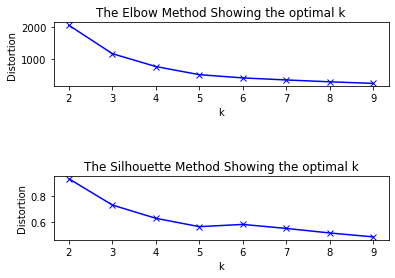

In [109]:
Kmeans.kmeans_train(data=df, columns=df.columns,
                    start_k=2, final_k=10,
                    sihouette_opt=True,
                    reduce_dim_opt=False)

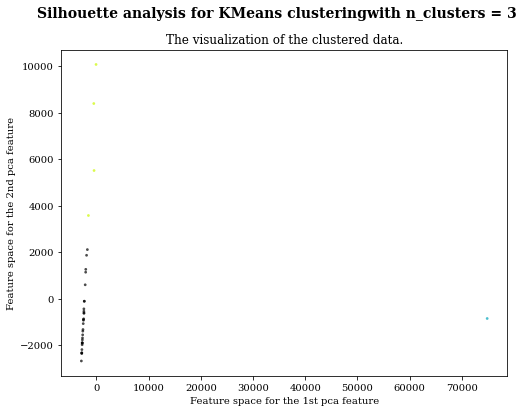

In [167]:
#k-means clustering
k_df = Kmeans.make_cluster(df, df.columns,3)

In [187]:
unf_dic = dict(zip(k_df.index, k_df['Cluster']))

net['k'] = net['modularity_class'].apply(lambda x : unf_dic.get(x))

In [141]:
net.head()

,Id,Label,timeset,modularity_class,indegree,outdegree,Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,eigencentrality,k
0,31156,31156,NaN,15,2,0,2,0,0.0,0.0,0.0,0.0,0.003243,2
1,42315,42315,NaN,19,195,0,195,0,0.0,0.0,0.0,0.0,0.052934,0
2,35392,35392,NaN,19,205,0,205,0,0.0,0.0,0.0,0.0,0.055621,0
3,54071,54071,NaN,16,7,0,7,0,0.0,0.0,0.0,0.0,0.055727,0
4,53441,53441,NaN,3,256,1,257,1,1.0,1.0,268.0,0.0,0.847134,0


In [113]:
#preprocessed dictionary about node features
node_dict = net[['k','modularity_class','eigencentrality','closnesscentrality','betweenesscentrality','Eccentricity']].T.to_dict()

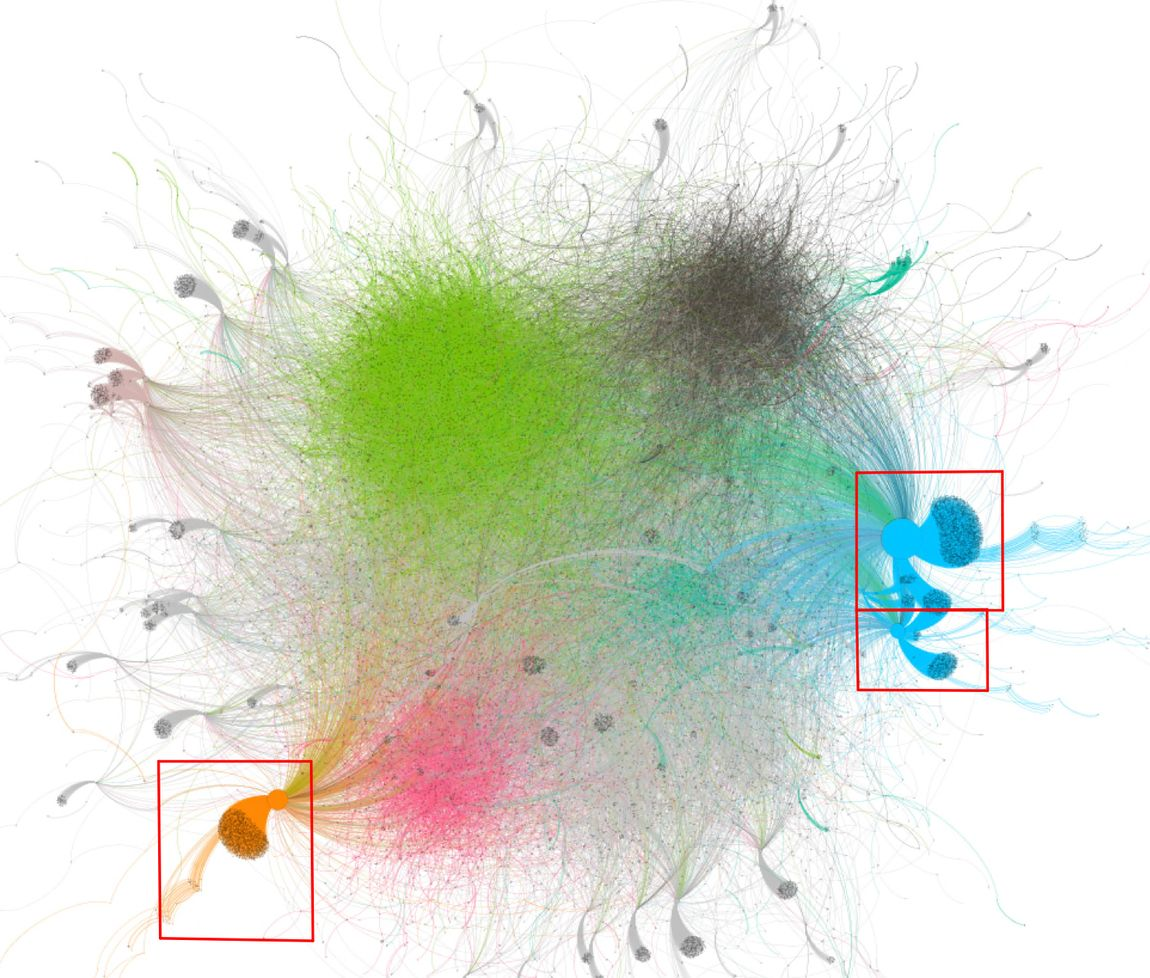

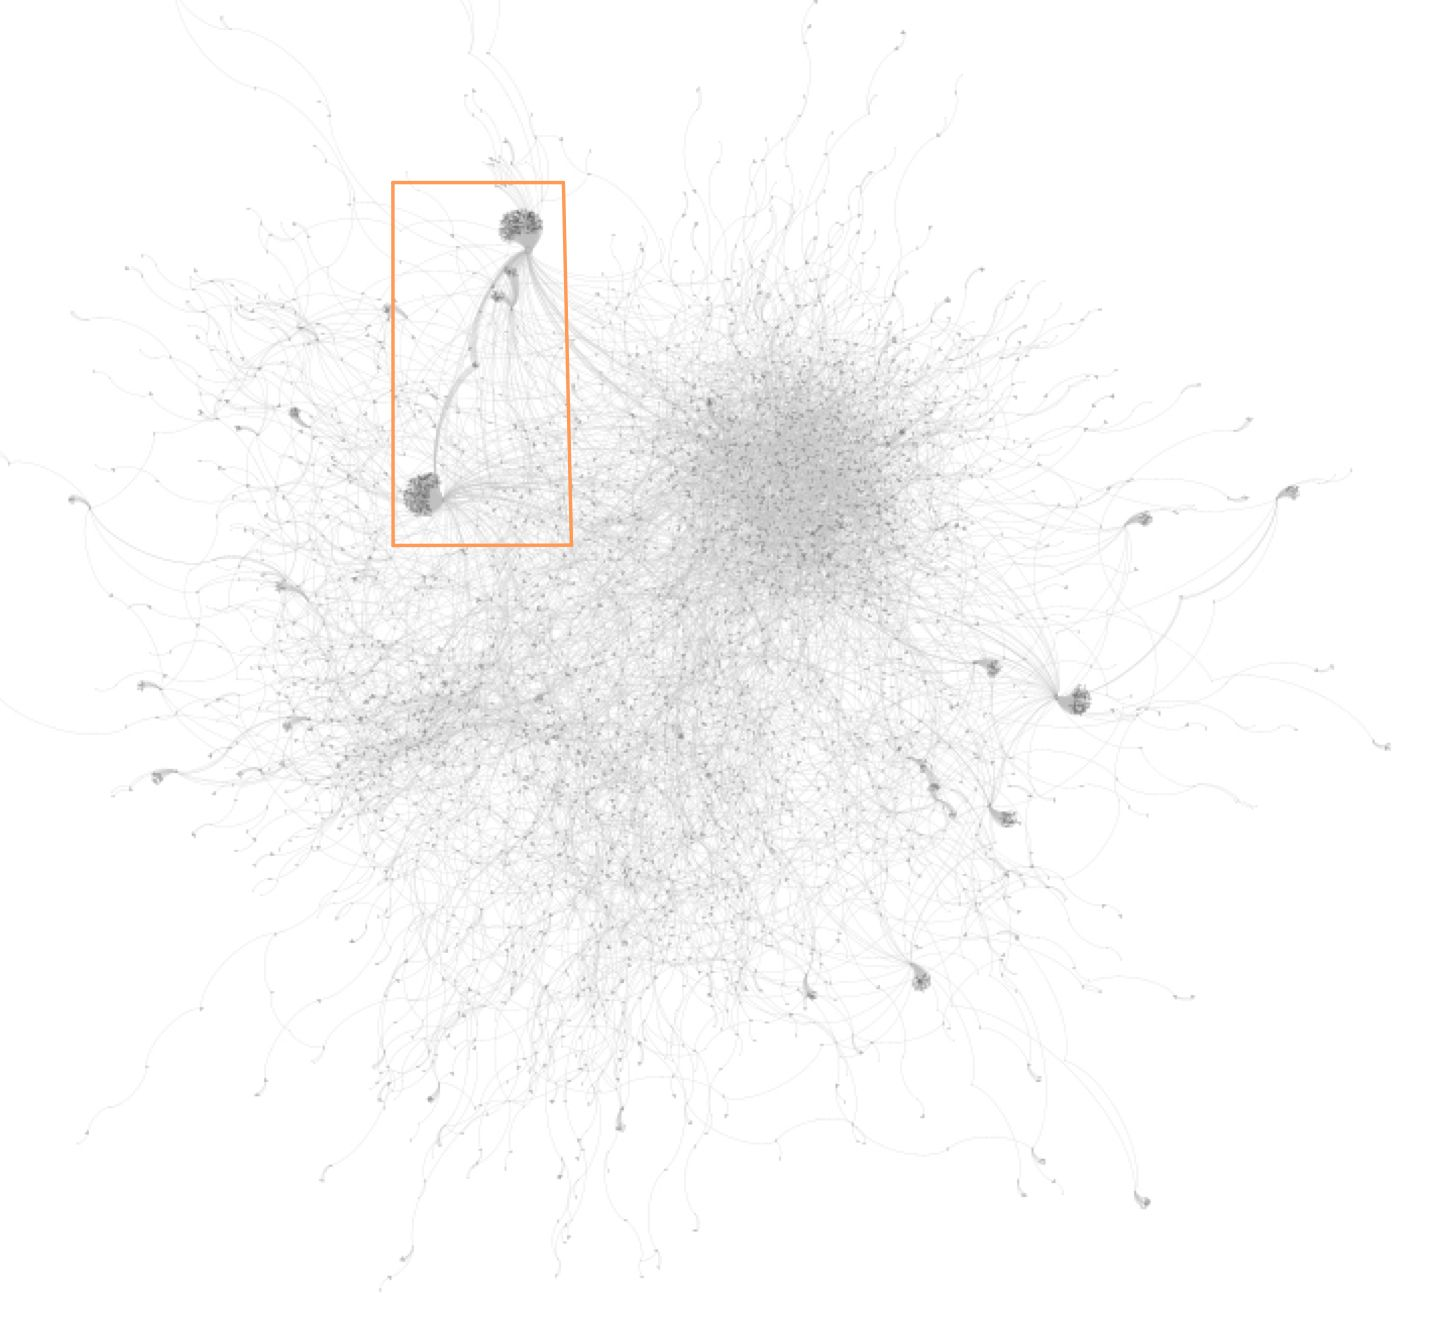

## Box plot

In [178]:
def BoxPlot(df_, col_list):
    # setting font
    df = df_.copy()
    sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
    
    for i in tqdm(range(len(df.Cluster.unique()))):
        df.loc[df.Cluster == i, "Cluster"] = f'Type{i}'
    
    # column list
    col_n = len(col_list)
    
    # Cluster name
    cluster_name = sorted(df["Cluster"].unique().tolist())
    
    # plotting
    fig, ax = plt.subplots(1,col_n, figsize = (20,6))
    fig.subplots_adjust(wspace=0.7)
    for k in range(col_n):
        c_name = col_list[k]
        ax[k] = sns.boxplot(ax = ax[k], 
                            x="Cluster", y=c_name,
                            data=df, 
                            palette="Set3"
                           )
        ax[k].tick_params(labelleft=False,left=False)  # remove the ticks
        ax[k].set_xticklabels(cluster_name, fontsize=12)
        ax[k].set_xlabel(f"{chr(k+1+64)}) {c_name}", fontsize = 17)
        ax[k].set_ylabel(f"{c_name}", fontsize = 13)
        
    return df

100%|█████████████████████████████████████████████████| 3/3 [00:00<00:00, 1851.24it/s]


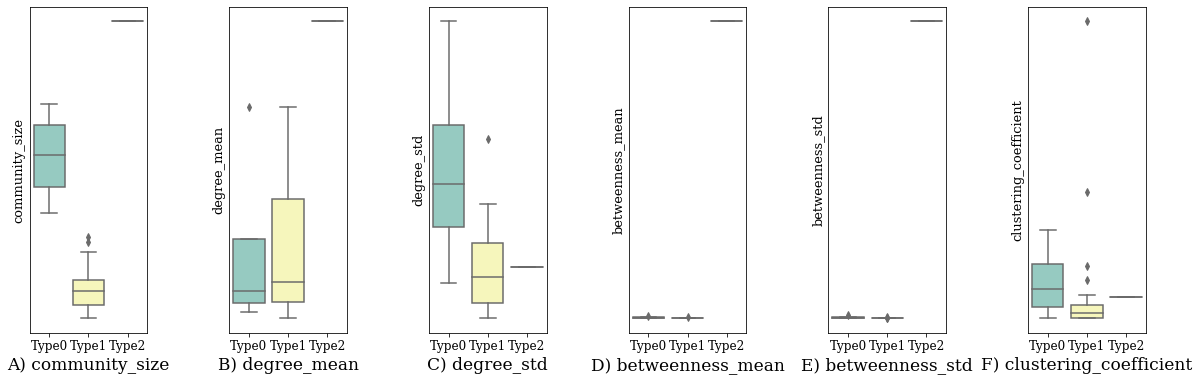

In [184]:
kf = BoxPlot(df,['community_size', 'degree_mean', 'degree_std','betweenness_mean','betweenness_std', 'clustering_coefficient'])

100%|█████████████████████████████████████████████████| 3/3 [00:00<00:00, 1531.51it/s]


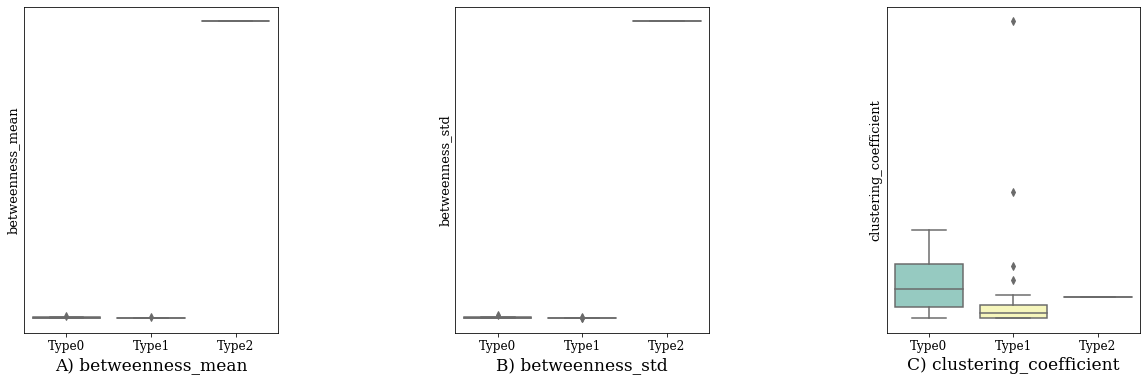

In [173]:
BoxPlot(df,['betweenness_mean','betweenness_std', 'clustering_coefficient'])

## To network

In [114]:
#load dataset
trade = pd.read_csv('./p_trade.csv')

In [115]:
## make graph
G_imp = nx.from_pandas_edgelist(trade,'source_acc_id','target_acc_id', create_using=nx.DiGraph(), edge_attr= 'item_amount')
nx.set_node_attributes(G_imp, node_dict)

In [116]:
##save gexf file 
nx.write_gexf(G_imp, "./3_clustered_trade.gexf")

* 최종적으로 user clustering label까지 고려하는 그래프

In [203]:
combined_cluster = pd.read_csv('./combined_cluster.csv',index_col=0)
#preprocessed dictionary about node features
combined_dict = combined_cluster[['k','modularity_class','eigencentrality','closnesscentrality','betweenesscentrality','Eccentricity','user_cluster']].T.to_dict()

In [204]:
## make graph
G_imp = nx.from_pandas_edgelist(trade,'source_acc_id','target_acc_id', create_using=nx.DiGraph(), edge_attr= 'item_amount')
nx.set_node_attributes(G_imp, combined_dict)

##save gexf file 
nx.write_gexf(G_imp, "./combined_trade.gexf")

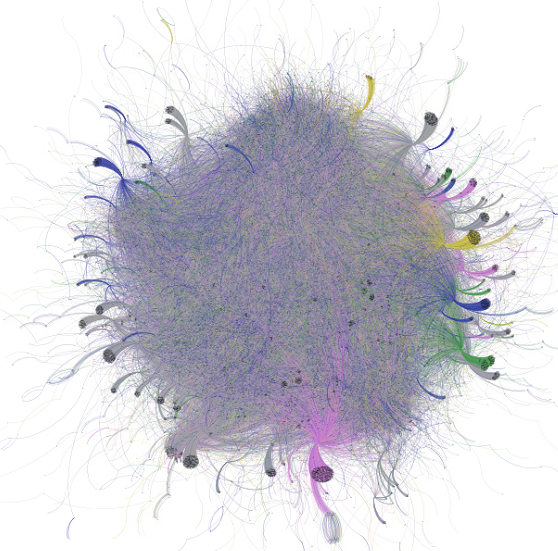